### Multi-response PLS

In [1]:
import numpy as np
import numpy.linalg as nplin

# Helper function
def issymmetric(X, rtol=1e-05, atol=1e-08):
    """
    Check if a matrix is symmetric (with tolerance)
    """
    if not np.diff(X.shape)[0] == 0:
        return False
    else:
        return np.allclose(X, X.T, rtol=rtol, atol=atol)

# Partial Least Squares Regression
def plsr(X, Y, ncomp='max', algorithm='auto'):
    """
    Just PLSR
    """
    E = X - np.mean(X, axis=0)
    F = Y - np.mean(Y, axis=0)
    n_obj, p = X.shape
    n_resp = Y.shape[1]
    
    if algorithm == 'auto':
        if n_obj > p:
            algorithm = 'NIPALS'
        else:
            algorithm = 'PKPLS'
    
    if ncomp == 'max':
        ncomp = min(n_obj-1, p)

    if algorithm == 'NIPALS':
        T = np.zeros([n_obj, ncomp])
        W = np.zeros([p, ncomp])
        P = W.copy()
        Q = np.zeros([n_resp, ncomp])
        
        for i in range(ncomp):
            w, _, _ = nplin.svd(E.T @ F, full_matrices=False); w = w[:,0:1]
            w = w / np.sqrt(np.sum(w**2))
            t = E @ w
            p = (E.T @ t) / np.sum(t**2)
            q = (F.T @ t) / np.sum(t**2)
            E = E - t @ p.T
            F = F - t @ q.T
            
            W[:,i] = w[:,0]
            T[:,i] = t[:,0]
            P[:,i] = p[:,0]
            Q[:,i] = q[:,0]

    if algorithm == 'PKPLS':
        if issymmetric(X):
            C = X
        else:
            C = E @ E.T
        Ry = np.zeros([n_obj, ncomp])
        T  = np.zeros([n_obj, ncomp])
        Q  = np.zeros([n_resp, ncomp])
        for i in range(ncomp):
            if n_resp == 1:
                t = C @ F
            else:
                tt = C @ F
                _, _, a = nplin.svd(F.T @ tt, full_matrices=False)
                t = tt @ a[:,:1]
            if i>0: # Orthogonalize on previous
                t = t - T[:,:i] @ (T[:,:i].T @ t)
            t = t / np.sqrt(np.sum(t**2))
            T [:,i:i+1] = t
            q = t.T @ F
            Q[:,i] = q
            if n_resp == 1:
                Ry[:,i:i+1] = F
            else:
                Ry[:,i:i+1] = F @ a[:,:1]
            F = F - t @ q
        W = X.T @ Ry
        W_norms = np.sqrt(np.sum(W**2, axis=0))
        for i in range(ncomp):
            W[:,i] = W[:,i]/W_norms[i]
        P = X.T @ T
    
    return W, P, T, Q

### Two level PLS-LDA + PLSR
Test set prediction

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Predict a set of samples
def TwoLevelPrediction(Xtrain, Ytrain, Gtrain, Xtest, ncompGroup, ncompLocal):
    """
    Inputs:
      Xtrain : features
      Ytrain : target/response
      Gtrain : groups for local models
      Xtest : features
      ncompGroups : number of pls components for classification
      ncompLocal : number of pls components for local models
    """
    # Classify
    Ydummy = OneHotEncoder(sparse=False).fit_transform(Gtrain)
    W, P, T, Q = plsr(Xtrain, Ydummy, ncomp=ncompGroup)
    clf = LDA()
    clf.fit(T, Gtrain[:,0])
    XtestG = Xtest - np.mean(Xtrain, axis=0)
    Gtest = clf.predict(XtestG @ (W@np.linalg.inv(P.T@W)))
    
    # Local prediction
    y = np.zeros((Xtest.shape[0]))
    for g in np.unique(Gtest):
        W, P, T, Q = plsr(Xtrain[Gtrain[:,0]==g,:], Ytrain[Gtrain[:,0]==g], ncomp=min(ncompLocal[g],sum(Gtrain[:,0]==g)-1))
        Xtestg = Xtest[Gtest==g,:] - np.mean(Xtrain[Gtrain[:,0]==g,:], axis=0)
        y[Gtest==g] = (Xtestg @ (W@np.linalg.inv(P.T@W)@Q.T) + np.mean(Ytrain[Gtrain[:,0]==g]))[:,0]
    return(y,Gtest)

### Load data

In [3]:
import scipy.io
FTIR_AMW = scipy.io.loadmat('FTIR_AMW.mat')
X = FTIR_AMW["spectraCorrectedShort"]
Y = FTIR_AMW["AMWall"]
group = FTIR_AMW["material"]-1
time  = FTIR_AMW["t3"][:,0]

In [4]:
ncompGroup = 50
ncompLocal = [4,1,5,15,13,13,9,10,7,4,3,3,1,4,1,2,4,8,7,9,19,18,14,11,6,17,4,6]

### Train test split

In [5]:
# Random selection of train and test data keeping group:time repetitions together
from sklearn.model_selection import train_test_split
group_time = group[:,0]*1000+time
gtu = np.unique(group_time)

_, _, train, test = train_test_split(
    np.arange(len(gtu)), np.arange(len(gtu)), test_size=0.3, random_state=42)

Xtrain = X[np.isin(group_time, gtu[train]),:]
Xtest  = X[np.isin(group_time, gtu[test]),:]
Ytrain = Y[np.isin(group_time, gtu[train]),:]
Ytest  = Y[np.isin(group_time, gtu[test]),:]
Gtrain = group[np.isin(group_time, gtu[train])]
Gtest  = group[np.isin(group_time, gtu[test])]

### Two-level prediction of test set

In [6]:
Ypred, Gpred = TwoLevelPrediction(Xtrain, Ytrain, Gtrain, Xtest, ncompGroup, ncompLocal)

In [7]:
print("RMSEP:", np.sqrt(np.mean(np.power((Ytest[:,0]-Ypred), 2))))
print("R2:    ", 100*(1 - np.mean(np.power((Ytest[:,0]-Ypred), 2)) / 
                      np.mean(np.power((Ytest[:,0]-np.mean(Ytest[:,0])), 2))))

RMSEP: 296.66733730818703
R2:     93.32556747020068


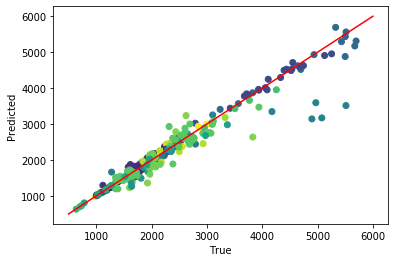

In [8]:
import matplotlib.pyplot as plt
plt.scatter(Ytest[:,0],Ypred, c = Gtest[:,0])
plt.plot([500,6000],[500,6000],'-r')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()